# Лабораторная работа 8

In [ ]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from tqdm import tqdm

## Загрузка датасета

In [ ]:

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.EuroSAT(
    root="./data",
    download=True,
    transform=transform
)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    train_dataset, [train_size, val_size]
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

print("Train size:", len(train_dataset))
print("Val size:", len(val_dataset))


Train size: 21600
Val size: 5400


Загружаем предобученный ResNet18, замораживаем параметры, заменяем слой классификации на новый

In [ ]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)

print("Trainable parameters (должны быть только fc):")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

model = model.to(device)


Device: cpu
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\roma/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100.0%


Trainable parameters (должны быть только fc):
fc.weight
fc.bias


Тренеровка модели

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

def train_one_epoch(model, loader):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total

def validate(model, loader):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total


EPOCHS = 5
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    tr_loss, tr_acc = train_one_epoch(model, train_loader)
    val_loss, val_acc = validate(model, val_loader)

    train_losses.append(tr_loss)
    val_losses.append(val_loss)
    train_accs.append(tr_acc)
    val_accs.append(val_acc)

    print(f"Train loss: {tr_loss:.4f}, acc: {tr_acc:.4f}")
    print(f"Val loss:   {val_loss:.4f}, acc: {val_acc:.4f}")

print("\nTraining finished!")



Epoch 1/5


  0%|          | 0/338 [00:00<?, ?it/s]

100%|██████████| 338/338 [09:27<00:00,  1.68s/it]


Train loss: 0.6385, acc: 0.8203
Val loss:   0.3247, acc: 0.8981

Epoch 2/5


100%|██████████| 338/338 [05:09<00:00,  1.09it/s]


Train loss: 0.3199, acc: 0.8993
Val loss:   0.2621, acc: 0.9135

Epoch 3/5


100%|██████████| 338/338 [05:08<00:00,  1.10it/s]


Train loss: 0.2692, acc: 0.9137
Val loss:   0.2302, acc: 0.9207

Epoch 4/5


100%|██████████| 338/338 [05:08<00:00,  1.10it/s]


Train loss: 0.2459, acc: 0.9186
Val loss:   0.2132, acc: 0.9267

Epoch 5/5


100%|██████████| 338/338 [05:08<00:00,  1.09it/s]


Train loss: 0.2330, acc: 0.9226
Val loss:   0.2111, acc: 0.9309

Training finished!


Визуализация

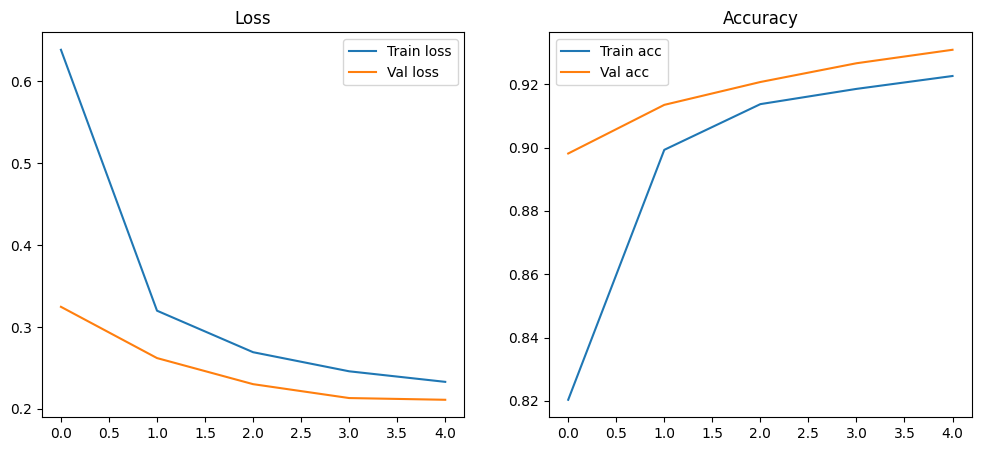

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Val loss')
plt.title("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train acc')
plt.plot(val_accs, label='Val acc')
plt.title("Accuracy")
plt.legend()

plt.show()


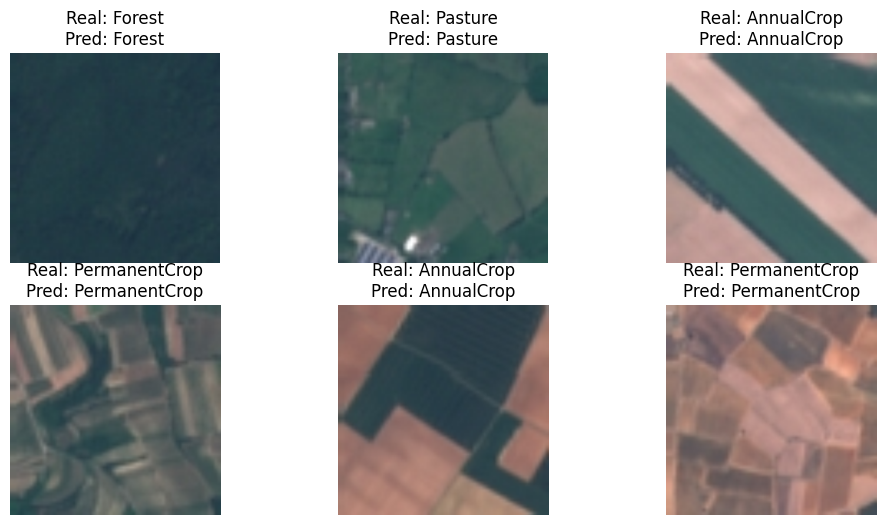

In [ ]:
import random
import numpy as np

classes = train_dataset.dataset.classes

model.eval()

# Выбираем 6 случайных изображений
indices = random.sample(range(len(val_dataset)), 6)

plt.figure(figsize=(12,6))

for i, idx in enumerate(indices):
    img, label = val_dataset[idx]
    img_tensor = img.unsqueeze(0).to(device)
    
    with torch.no_grad():
        pred = model(img_tensor)
        pred_class = pred.argmax(dim=1).item()
    
    img_np = img.permute(1, 2, 0).numpy()

    plt.subplot(2, 3, i+1)
    plt.imshow(img_np)
    plt.axis("off")
    plt.title(f"Real: {classes[label]}\nPred: {classes[pred_class]}")
    
plt.show()
